# hourly_visualisation

This notebook visualises the hourly data of IES results .txt file.

Use ***Shift-Enter*** or ***Ctrl-Enter*** to run the code cells.

The notebook creates plots in the notebook itself and it also saves these plots in the folder 'hourly_visualisation_outputs'.

The notebook creates plots for one weather variable at a time. This variable can be changed in Step 4.

## Step 1: Choose the file to visualise

The weather data in IES VistaPro can be exported using the Save icon when viewing a table. To do this:

- Run an IES simulation
- Go to the VistaPro results module
- Select the weather data variables of interest
- View these variable in a table
- Click on the ***save*** icon to export this data as a .txt file.

The name/path for the IES weather .txt file can then be specified in the code cell below.

In [19]:
filename='MyResultsWeatherAndModel.txt'

## Step 2: Run the code below to import the file

In [20]:
import pandas as pd
def convert_txt_to_csv(filename):
    try:
        df=pd.read_csv(filename,sep='\t',encoding = 'unicode_escape',header=[0,1,2])
        df.columns=pd.MultiIndex.from_arrays([df.columns.get_level_values(0),
                                              [x if not x.startswith('Unnamed') else 'NA' for x in df.columns.get_level_values(1)],
                                              df.columns.get_level_values(2)])
    except pd.errors.ParserError:
        df=pd.read_csv(filename,sep='\t',encoding = 'unicode_escape',header=[0,2])
        df.columns=pd.MultiIndex.from_arrays([df.columns.get_level_values(0),
                                              ['NA']*len(df.columns.get_level_values(0)),
                                              df.columns.get_level_values(1)])
    df.columns=df.columns.set_names(['variable_name', 'zone_name','file_name'])
    
    df[df.columns[0]]=df[df.columns[0]].fillna(method='ffill')
    df[df.columns[0]]=df[df.columns[0]].str[5:] + r'/2003'
    df[df.columns[1]]=df[df.columns[1]].replace(to_replace='24:00',value='00:00')
    df.insert(0,column='datetime',value=pd.to_datetime(df[df.columns[0]]+' '+df[df.columns[1]],format='%d/%b/%Y %H:%M'))
    df=df.drop(columns=[df.columns[1],df.columns[2]])
    df=df.set_index(df.columns[0])
    df.index=df.index.rename('datetime')
    
    new_filename=filename+'.csv'
    df.to_csv(new_filename)
    print('NEW FILENAME: ' + new_filename)
    return df
df=convert_txt_to_csv(filename)
df.head()

NEW FILENAME: MyResultsWeatherAndModel.txt.csv


variable_name,Air temperature (°C),Dry-bulb temperature (°C)
zone_name,South Zone,NA
file_name,Small_Office.aps,KEW.FWT
datetime,,
2003-01-01 00:00:00,NaN,NaN
2003-01-01 00:30:00,19.0,NaN
2003-01-01 01:00:00,NaN,4.8
2003-01-01 01:30:00,19.0,NaN
2003-01-01 02:00:00,NaN,4.7


## Step 3: View the weather variables available

In [21]:
for x in list(df.columns): print(x)

('Air temperature (°C)', 'South Zone', 'Small_Office.aps')
('Dry-bulb temperature (°C)', 'NA', 'KEW.FWT')


## Step 4: Choose the weather variable to analysis

The weather variables are listed in Step 3. One variable is chosen for analysis in the code cell below.

In [44]:
var=('Dry-bulb temperature (°C)', 'NA', 'KEW.FWT')
#var=('Air temperature (°C)', 'South Zone', 'Small_Office.aps')

## Step 5: Create and save an hourly time-series plot

VARIABLE:  ('Dry-bulb temperature (°C)', 'NA', 'KEW.FWT')
PLOT_FILENAME: hourly_timeseries_Dry-bulb temperature (°C)_NA_KEW.FWT.png


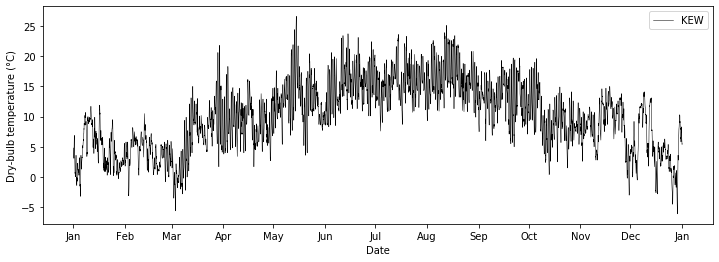

In [45]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
fig, ax = plt.subplots(1,figsize=(12,4))
ax.plot(df[var].dropna(),color='black',linewidth=0.5,label=(var[1]+', ' if not var[1]=='NA' else '') + var[2].split('.')[0])
ax.set_xlabel('Date')
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
var_name=var[0].split(' (')[0]
unit=var[0].split(' (')[1].split(')')[0]
ax.set_ylabel(var_name + ' (' + unit + ')')
ax.legend()
plot_filename=r'hourly_timeseries_'+'_'.join(var)+'.png'
print('VARIABLE: ',var)
print('PLOT_FILENAME: '+plot_filename)
plt.savefig(plot_filename, bbox_inches='tight')
plt.show()

## Step 6: Create and save a 2D heatmap plot

Other heatmap colors can be chosen here: https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html and substituted instead of 'gray' in the `cmap` keyword argument of `imshow`.


VARIABLE:  ('Dry-bulb temperature (°C)', 'NA', 'KEW.FWT')
PLOT_FILENAME: hourly_2D_heatmap_Dry-bulb temperature (°C)_NA_KEW.FWT.png


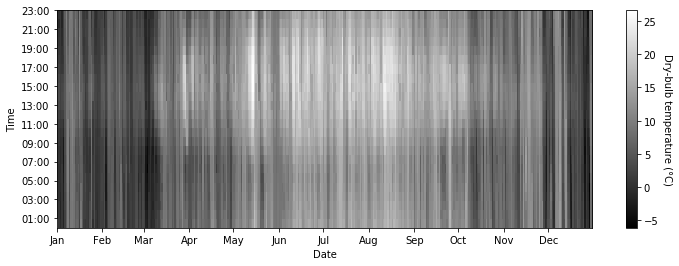

In [46]:
df1=df[[var]].dropna().copy()
df1['date']=df1.index.date
df1['time']=df1.index.time
df1=df1.pivot(index='time',columns='date',values=var)
df1=df1.iloc[::-1] # reverses the rows
fig, ax = plt.subplots(1,figsize=(12,4))
xmin,xmax=mdates.date2num([df1.columns[0],df1.columns[-1]])
ymin,ymax=mdates.date2num([pd.Timestamp(str(df1.index[-1])),pd.Timestamp(str(df1.index[0]))])
im=ax.imshow(df1, cmap='gray',interpolation='nearest',aspect='auto',extent=[xmin, xmax, ymin, ymax])
cbar = ax.figure.colorbar(im, ax=ax)
var_name=var[0].split(' (')[0]
unit=var[0].split(' (')[1].split(')')[0]
cbar.ax.set_ylabel(var_name+ ' (' + unit + ')', rotation=-90, va="bottom")
ax.xaxis_date()
ax.set_xlabel('Date')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax.yaxis_date()
ax.set_ylabel('Time')
ax.yaxis.set_major_locator(mdates.HourLocator(interval=2))
ax.yaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plot_filename=r'hourly_2D_heatmap_'+'_'.join(var)+'.png'
print('VARIABLE: ',var)
print('PLOT_FILENAME: '+plot_filename)
plt.savefig(plot_filename, bbox_inches='tight')
plt.show()

## Step 7: Create and save a frequency histogram plot

VARIABLE:  ('Dry-bulb temperature (°C)', 'NA', 'KEW.FWT')
PLOT_FILENAME: hourly_frequency_histogram_Dry-bulb temperature (°C)_NA_KEW.FWT.png


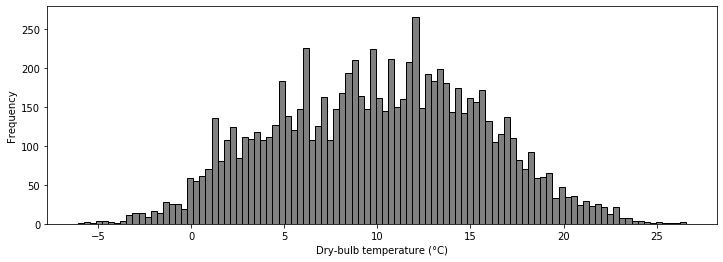

In [47]:
fig, ax = plt.subplots(1,figsize=(12,4))
ax.hist(df[var].dropna(),color='gray',edgecolor='black',bins=100)
var_name=var[0].split(' (')[0]
unit=var[0].split(' (')[1].split(')')[0]
ax.set_xlabel(var_name+ ' (' + unit + ')')
ax.set_ylabel('Frequency')
plot_filename=r'hourly_frequency_histogram_'+'_'.join(var)+'.png'
print('VARIABLE: ',var)
print('PLOT_FILENAME: '+plot_filename)
plt.savefig(plot_filename, bbox_inches='tight')
plt.show()

## Step 8: Create and save a percentage frequency histogram plot

Needs revising as percentages do not sum to 100%

VARIABLE:  ('Dry-bulb temperature (°C)', 'NA', 'KEW.FWT')
PLOT_FILENAME: hourly_percentage_frequency_histogram_Dry-bulb temperature (°C)_NA_KEW.FWT.png


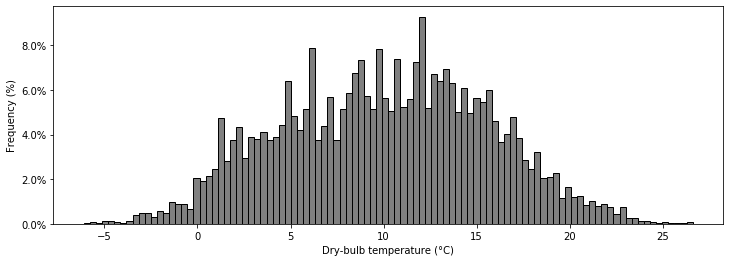

In [49]:
import matplotlib.ticker as mtick
fig, ax = plt.subplots(1,figsize=(12,4))
ax.hist(df[var].dropna(),density=True,color='gray',edgecolor='black',bins=100)
var_name=var[0].split(' (')[0]
unit=var[0].split(' (')[1].split(')')[0]
ax.set_xlabel(var_name+ ' (' + unit + ')')
ax.set_ylabel('Frequency (%)')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
plot_filename=r'hourly_percentage_frequency_histogram_'+'_'.join(var)+'.png'
print('VARIABLE: ',var)
print('PLOT_FILENAME: '+plot_filename)
plt.savefig(plot_filename, bbox_inches='tight')
plt.show()

## Step 9: Create and save a cumulative histogram plot

VARIABLE:  ('Dry-bulb temperature (°C)', 'NA', 'KEW.FWT')
PLOT_FILENAME: hourly_cumulative_histogram_Dry-bulb temperature (°C)_NA_KEW.FWT.png


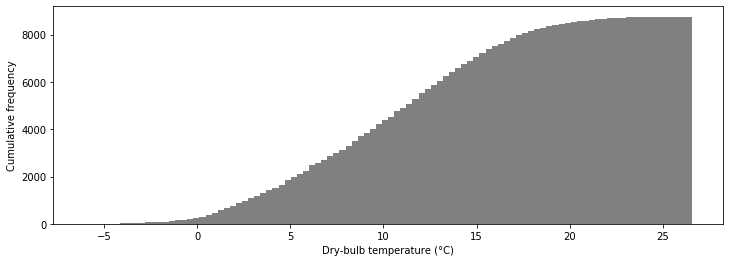

In [50]:
fig, ax = plt.subplots(1,figsize=(12,4))
ax.hist(df[var].dropna(),cumulative=True,color='gray',bins=100)
var_name=var[0].split(' (')[0]
unit=var[0].split(' (')[1].split(')')[0]
ax.set_xlabel(var_name+ ' (' + unit + ')')
ax.set_ylabel('Cumulative frequency')
plot_filename=r'hourly_cumulative_histogram_'+'_'.join(var)+'.png'
print('VARIABLE: ',var)
print('PLOT_FILENAME: '+plot_filename)
plt.savefig(plot_filename, bbox_inches='tight')
plt.show()

## Step 10: Create and save a percentage cumulative histogram plot

VARIABLE:  ('Dry-bulb temperature (°C)', 'NA', 'KEW.FWT')
PLOT_FILENAME: hourly_percentage_cumulative_histogram_Dry-bulb temperature (°C)_NA_KEW.FWT.png


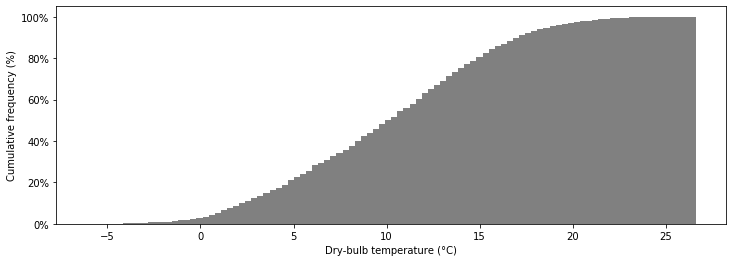

In [51]:
fig, ax = plt.subplots(1,figsize=(12,4))
ax.hist(df[var].dropna(),cumulative=True,density=True,color='gray',bins=100)
var_name=var[0].split(' (')[0]
unit=var[0].split(' (')[1].split(')')[0]
ax.set_xlabel(var_name+ ' (' + unit + ')')
ax.set_ylabel('Cumulative frequency (%)')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
plot_filename=r'hourly_percentage_cumulative_histogram_'+'_'.join(var)+'.png'
print('VARIABLE: ',var)
print('PLOT_FILENAME: '+plot_filename)
plt.savefig(plot_filename, bbox_inches='tight')
plt.show()